# Linear Regression and Logistic Regression
In this exercise we will be implementing two types of linear classifiers that will classify between digits in the MNIST dataset. We will be using training data to learn two 10-class classifiers using linear regression and logistic regression, and report the best possible classification performance in the held-out test images

In [1]:
# some startup
import numpy as np
import src.data_utils as util
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading modules
%load_ext autoreload
%autoreload 2

In [2]:
def get_MNIST_data(num_training=50000, num_validation=10000):
    path_to_dataset = 'data/datasets'

    # load raw MNIST data
    # https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py
    X_train, y_train = util.load_mnist('training', path=path_to_dataset, return_labels=True)
    X_test, y_test = util.load_mnist('testing', path=path_to_dataset, return_labels=True)
    
    # subsample training data to training and validation data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]

    # reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))

    # normalize the data by subtracting the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_MNIST_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (50000, 785)
Train labels shape:  (50000,)
Validation data shape:  (10000, 785)
Validation labels shape:  (10000,)
Test data shape:  (10000, 785)
Test labels shape:  (10000,)


# Linear Regression
Here we'll be using a multiclass linear regression model to classify our data. Specifically, we'll be using Ordinary Least Squares (OLS) as our classifier. Our model is in the form $y=X\beta$, where the least squares solution solves the problem $\hat{\beta}=\arg\text{min}{\|X\beta-y\|_2}$. The closed form solution is $\hat{\beta}=(X^TX)^{-1}X^Ty$.

In [5]:
def predict(X, W):
    y_pred = X.dot(W).argmax(axis=1)
    return y_pred

num_train, dim = X_train.shape
num_classes = np.max(y_train) + 1  # assuming y labels are 0..K

# we'll create multiple one vs. all label vectors y
# where y[i,j] = +1 if digit is j, -1 otherwise
y_train_digits = np.zeros((num_train, num_classes))

# we need to create a least squares classifier for each label versus the others
B_hat_digits = np.zeros((dim, num_classes))

for i in range(0, num_classes):
    temp = y_train.copy()
    temp[temp != i] = -1  # -1 for incorrect labels
    temp[temp == i] = 1  # +1 for correct labels
    y_train_digits[:,i] = temp
    
    # parameters for solving digit i
    print 'Solving for digit %d' % i
    B_hat_digits[:,i] = np.linalg.pinv(X_train).dot(y_train_digits[:,i])

Solving for digit 0
Solving for digit 1
Solving for digit 2
Solving for digit 3
Solving for digit 4
Solving for digit 5
Solving for digit 6
Solving for digit 7
Solving for digit 8
Solving for digit 9


Let's report the final test set accuracy. We'll also output a precision-recall summary and a confusion matrix.

In [6]:
# evaluate on test set
y_pred = predict(X_test, B_hat_digits)
accuracy = np.mean(y_test == y_pred)
print 'Ordinary Least Squares on raw pixels final test set accuracy: %f' % (accuracy, )

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

print("Classification report for classifier %s:\n%s\n"
      % ('OLS linear regressor', metrics.classification_report(y_test, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

Ordinary Least Squares on raw pixels final test set accuracy: 0.860600
Classification report for classifier OLS linear regressor:
             precision    recall  f1-score   support

          0       0.90      0.96      0.93       980
          1       0.83      0.97      0.90      1135
          2       0.92      0.78      0.84      1032
          3       0.85      0.87      0.86      1010
          4       0.82      0.90      0.86       982
          5       0.88      0.74      0.81       892
          6       0.88      0.91      0.90       958
          7       0.86      0.86      0.86      1028
          8       0.84      0.78      0.81       974
          9       0.84      0.80      0.82      1009

avg / total       0.86      0.86      0.86     10000


Confusion matrix:
[[ 942    0    2    2    2    8   14    2    7    1]
 [   0 1106    3    2    2    1    5    1   15    0]
 [  19   55  805   28   17    1   41   20   40    6]
 [   4   19   23  883    4   17    9   21   20   10]


# Logistic Regression
Here we'll be using a multiclass logistic regression model to classify our data. Specifically, we'll be using the Softmax classifier while using a cross-entropy loss. We will be using an iterative approach, using mini-batch stochastic gradient descent.

If you want to skip the training step (after this code cell), you can just directly load the pre-trained model by executing this code cell.

In [6]:
import dill
with open('data/pretrained/best_softmax.pkl', 'rb') as f:
    best_softmax = dill.load(f)

epoch (1 / 24): loss: 2.302883 train acc: 0.738333 val acc: 0.716900 lr: 1.000000
epoch (2 / 24): loss: 0.362700 train acc: 0.905000 val acc: 0.908400 lr: 1.000000
epoch (3 / 24): loss: 0.361900 train acc: 0.896667 val acc: 0.914400 lr: 1.000000
epoch (4 / 24): loss: 0.333939 train acc: 0.901667 val acc: 0.917200 lr: 1.000000
epoch (5 / 24): loss: 0.252175 train acc: 0.936667 val acc: 0.919200 lr: 1.000000
epoch (6 / 24): loss: 0.295212 train acc: 0.921667 val acc: 0.918900 lr: 1.000000
epoch (7 / 24): loss: 0.312834 train acc: 0.918333 val acc: 0.921200 lr: 1.000000
epoch (8 / 24): loss: 0.258930 train acc: 0.930000 val acc: 0.920000 lr: 1.000000
epoch (9 / 24): loss: 0.309668 train acc: 0.908333 val acc: 0.920800 lr: 1.000000
epoch (10 / 24): loss: 0.242599 train acc: 0.940000 val acc: 0.922300 lr: 1.000000
epoch (11 / 24): loss: 0.232300 train acc: 0.923333 val acc: 0.922400 lr: 1.000000
epoch (12 / 24): loss: 0.283433 train acc: 0.933333 val acc: 0.924200 lr: 1.000000
epoch (13 / 2

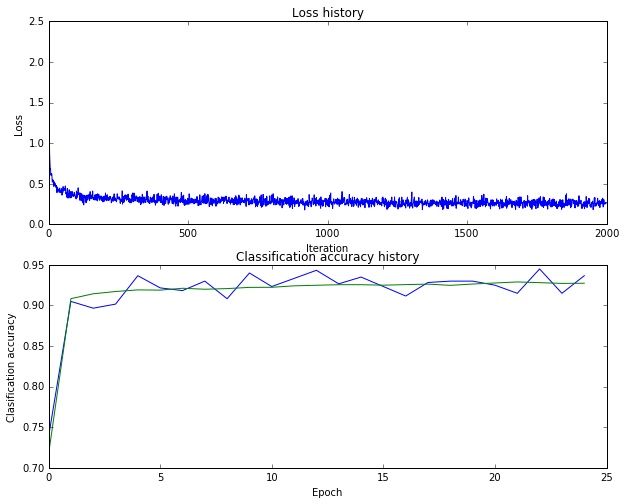

epoch (1 / 24): loss: 2.304493 train acc: 0.728333 val acc: 0.720400 lr: 1.000000
epoch (2 / 24): loss: 1.416217 train acc: 0.865000 val acc: 0.837700 lr: 1.000000
epoch (3 / 24): loss: 1.419953 train acc: 0.841667 val acc: 0.844400 lr: 1.000000
epoch (4 / 24): loss: 1.446201 train acc: 0.811667 val acc: 0.837900 lr: 1.000000
epoch (5 / 24): loss: 1.443337 train acc: 0.815000 val acc: 0.826000 lr: 1.000000
epoch (6 / 24): loss: 1.463429 train acc: 0.836667 val acc: 0.834500 lr: 1.000000
epoch (7 / 24): loss: 1.426950 train acc: 0.848333 val acc: 0.842600 lr: 1.000000
epoch (8 / 24): loss: 1.422212 train acc: 0.851667 val acc: 0.845400 lr: 1.000000
epoch (9 / 24): loss: 1.409739 train acc: 0.861667 val acc: 0.843000 lr: 1.000000
epoch (10 / 24): loss: 1.417484 train acc: 0.835000 val acc: 0.837000 lr: 1.000000
epoch (11 / 24): loss: 1.440085 train acc: 0.816667 val acc: 0.830000 lr: 1.000000
epoch (12 / 24): loss: 1.433862 train acc: 0.841667 val acc: 0.840500 lr: 1.000000
epoch (13 / 2

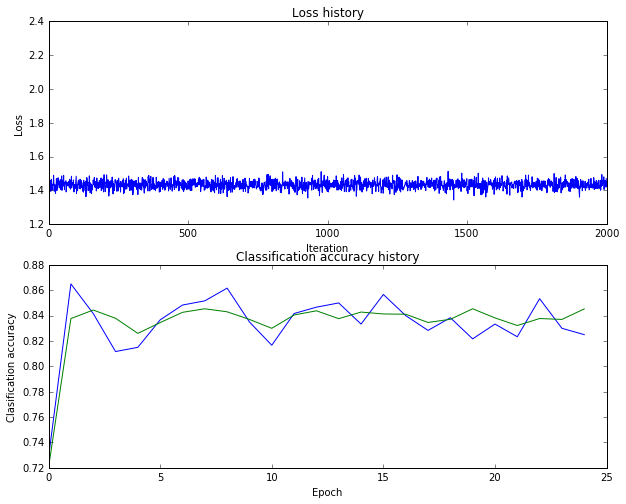

epoch (1 / 24): loss: 2.304704 train acc: 0.720000 val acc: 0.684300 lr: 1.000000
epoch (2 / 24): loss: 1.676147 train acc: 0.805000 val acc: 0.799500 lr: 1.000000
epoch (3 / 24): loss: 1.724287 train acc: 0.813333 val acc: 0.801700 lr: 1.000000
epoch (4 / 24): loss: 1.673674 train acc: 0.810000 val acc: 0.809300 lr: 1.000000
epoch (5 / 24): loss: 1.740049 train acc: 0.808333 val acc: 0.830100 lr: 1.000000
epoch (6 / 24): loss: 1.679625 train acc: 0.853333 val acc: 0.813200 lr: 1.000000
epoch (7 / 24): loss: 1.720370 train acc: 0.791667 val acc: 0.805900 lr: 1.000000
epoch (8 / 24): loss: 1.691600 train acc: 0.796667 val acc: 0.787900 lr: 1.000000
epoch (9 / 24): loss: 1.692133 train acc: 0.786667 val acc: 0.810800 lr: 1.000000
epoch (10 / 24): loss: 1.647907 train acc: 0.823333 val acc: 0.794500 lr: 1.000000
epoch (11 / 24): loss: 1.641863 train acc: 0.835000 val acc: 0.798600 lr: 1.000000
epoch (12 / 24): loss: 1.688770 train acc: 0.818333 val acc: 0.795500 lr: 1.000000
epoch (13 / 2

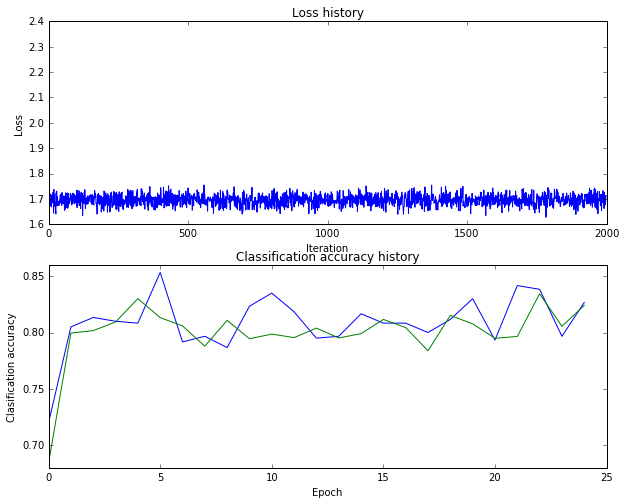

epoch (1 / 24): loss: 2.302932 train acc: 0.750000 val acc: 0.723000 lr: 0.700000
epoch (2 / 24): loss: 0.399568 train acc: 0.896667 val acc: 0.903200 lr: 0.700000
epoch (3 / 24): loss: 0.321479 train acc: 0.913333 val acc: 0.910600 lr: 0.700000
epoch (4 / 24): loss: 0.297653 train acc: 0.913333 val acc: 0.914900 lr: 0.700000
epoch (5 / 24): loss: 0.319726 train acc: 0.913333 val acc: 0.917100 lr: 0.700000
epoch (6 / 24): loss: 0.299891 train acc: 0.903333 val acc: 0.919700 lr: 0.700000
epoch (7 / 24): loss: 0.360508 train acc: 0.898333 val acc: 0.919900 lr: 0.700000
epoch (8 / 24): loss: 0.288431 train acc: 0.921667 val acc: 0.919600 lr: 0.700000
epoch (9 / 24): loss: 0.258535 train acc: 0.928333 val acc: 0.920900 lr: 0.700000
epoch (10 / 24): loss: 0.285612 train acc: 0.916667 val acc: 0.922700 lr: 0.700000
epoch (11 / 24): loss: 0.285990 train acc: 0.916667 val acc: 0.923200 lr: 0.700000
epoch (12 / 24): loss: 0.274423 train acc: 0.923333 val acc: 0.922500 lr: 0.700000
epoch (13 / 2

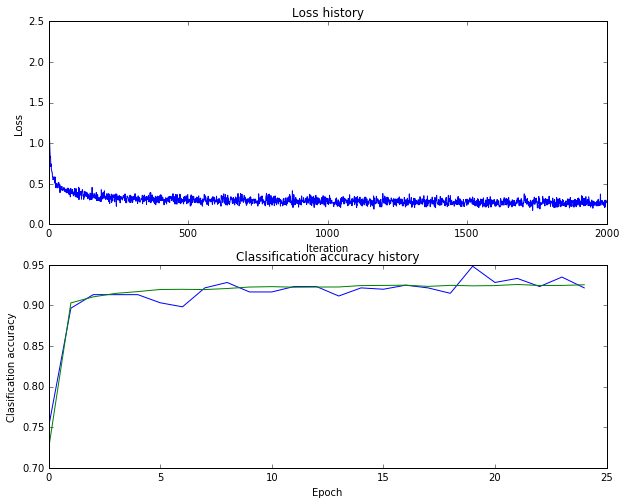

epoch (1 / 24): loss: 2.303200 train acc: 0.738333 val acc: 0.711300 lr: 0.700000
epoch (2 / 24): loss: 1.408874 train acc: 0.835000 val acc: 0.842000 lr: 0.700000
epoch (3 / 24): loss: 1.381040 train acc: 0.840000 val acc: 0.840500 lr: 0.700000
epoch (4 / 24): loss: 1.425608 train acc: 0.831667 val acc: 0.845800 lr: 0.700000
epoch (5 / 24): loss: 1.422291 train acc: 0.853333 val acc: 0.843600 lr: 0.700000
epoch (6 / 24): loss: 1.437008 train acc: 0.825000 val acc: 0.840900 lr: 0.700000
epoch (7 / 24): loss: 1.413000 train acc: 0.826667 val acc: 0.839400 lr: 0.700000
epoch (8 / 24): loss: 1.444880 train acc: 0.816667 val acc: 0.834200 lr: 0.700000
epoch (9 / 24): loss: 1.395114 train acc: 0.840000 val acc: 0.839400 lr: 0.700000
epoch (10 / 24): loss: 1.441450 train acc: 0.828333 val acc: 0.839800 lr: 0.700000
epoch (11 / 24): loss: 1.418907 train acc: 0.833333 val acc: 0.840200 lr: 0.700000
epoch (12 / 24): loss: 1.439676 train acc: 0.853333 val acc: 0.845900 lr: 0.700000
epoch (13 / 2

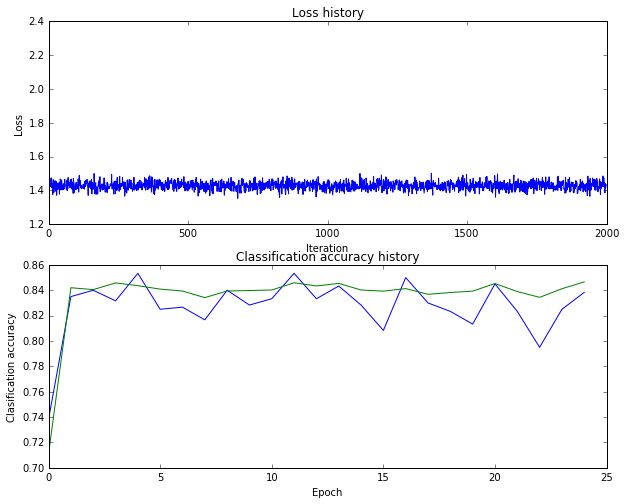

epoch (1 / 24): loss: 2.305322 train acc: 0.740000 val acc: 0.722200 lr: 0.700000
epoch (2 / 24): loss: 1.688041 train acc: 0.798333 val acc: 0.793200 lr: 0.700000
epoch (3 / 24): loss: 1.661657 train acc: 0.823333 val acc: 0.815500 lr: 0.700000
epoch (4 / 24): loss: 1.656618 train acc: 0.838333 val acc: 0.807400 lr: 0.700000
epoch (5 / 24): loss: 1.686686 train acc: 0.813333 val acc: 0.800100 lr: 0.700000
epoch (6 / 24): loss: 1.682773 train acc: 0.821667 val acc: 0.819000 lr: 0.700000
epoch (7 / 24): loss: 1.641344 train acc: 0.810000 val acc: 0.799000 lr: 0.700000
epoch (8 / 24): loss: 1.692425 train acc: 0.816667 val acc: 0.815200 lr: 0.700000
epoch (9 / 24): loss: 1.677470 train acc: 0.806667 val acc: 0.806300 lr: 0.700000
epoch (10 / 24): loss: 1.712688 train acc: 0.805000 val acc: 0.817400 lr: 0.700000
epoch (11 / 24): loss: 1.684631 train acc: 0.783333 val acc: 0.806800 lr: 0.700000
epoch (12 / 24): loss: 1.680091 train acc: 0.811667 val acc: 0.805700 lr: 0.700000
epoch (13 / 2

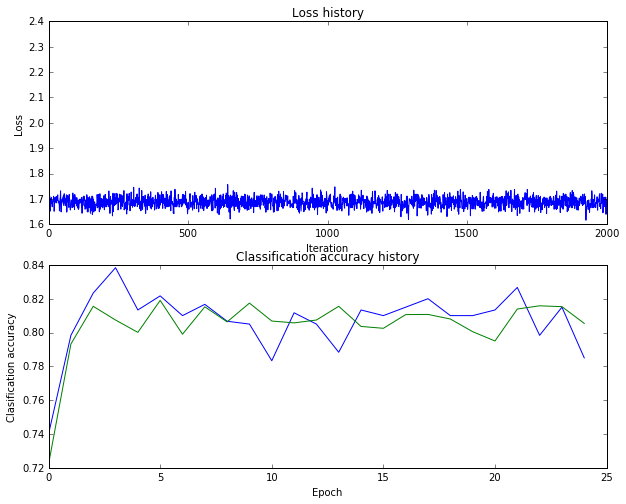

epoch (1 / 24): loss: 2.303241 train acc: 0.775000 val acc: 0.768800 lr: 0.500000
epoch (2 / 24): loss: 0.420099 train acc: 0.888333 val acc: 0.899600 lr: 0.500000
epoch (3 / 24): loss: 0.377690 train acc: 0.903333 val acc: 0.909100 lr: 0.500000
epoch (4 / 24): loss: 0.298409 train acc: 0.930000 val acc: 0.912300 lr: 0.500000
epoch (5 / 24): loss: 0.299328 train acc: 0.920000 val acc: 0.914100 lr: 0.500000
epoch (6 / 24): loss: 0.363197 train acc: 0.906667 val acc: 0.915500 lr: 0.500000
epoch (7 / 24): loss: 0.340013 train acc: 0.903333 val acc: 0.917800 lr: 0.500000
epoch (8 / 24): loss: 0.294430 train acc: 0.905000 val acc: 0.920000 lr: 0.500000
epoch (9 / 24): loss: 0.416907 train acc: 0.880000 val acc: 0.920400 lr: 0.500000
epoch (10 / 24): loss: 0.286977 train acc: 0.928333 val acc: 0.919100 lr: 0.500000
epoch (11 / 24): loss: 0.282730 train acc: 0.926667 val acc: 0.919300 lr: 0.500000
epoch (12 / 24): loss: 0.301749 train acc: 0.910000 val acc: 0.920700 lr: 0.500000
epoch (13 / 2

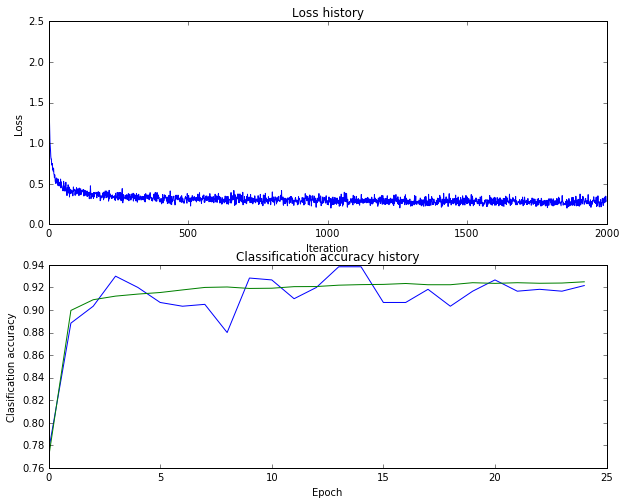

epoch (1 / 24): loss: 2.305197 train acc: 0.736667 val acc: 0.715200 lr: 0.500000
epoch (2 / 24): loss: 1.429738 train acc: 0.821667 val acc: 0.842700 lr: 0.500000
epoch (3 / 24): loss: 1.435747 train acc: 0.826667 val acc: 0.841700 lr: 0.500000
epoch (4 / 24): loss: 1.401337 train acc: 0.843333 val acc: 0.844500 lr: 0.500000
epoch (5 / 24): loss: 1.420091 train acc: 0.841667 val acc: 0.842900 lr: 0.500000
epoch (6 / 24): loss: 1.402458 train acc: 0.861667 val acc: 0.839300 lr: 0.500000
epoch (7 / 24): loss: 1.400695 train acc: 0.841667 val acc: 0.846400 lr: 0.500000
epoch (8 / 24): loss: 1.419028 train acc: 0.836667 val acc: 0.843500 lr: 0.500000
epoch (9 / 24): loss: 1.470930 train acc: 0.796667 val acc: 0.840800 lr: 0.500000
epoch (10 / 24): loss: 1.417992 train acc: 0.841667 val acc: 0.840300 lr: 0.500000
epoch (11 / 24): loss: 1.437017 train acc: 0.831667 val acc: 0.845900 lr: 0.500000
epoch (12 / 24): loss: 1.434752 train acc: 0.830000 val acc: 0.837800 lr: 0.500000
epoch (13 / 2

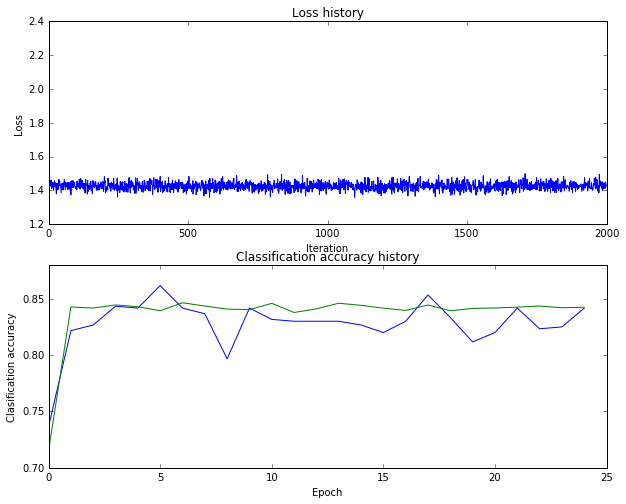

epoch (1 / 24): loss: 2.306503 train acc: 0.756667 val acc: 0.729300 lr: 0.500000
epoch (2 / 24): loss: 1.679782 train acc: 0.820000 val acc: 0.820000 lr: 0.500000
epoch (3 / 24): loss: 1.657037 train acc: 0.828333 val acc: 0.814000 lr: 0.500000
epoch (4 / 24): loss: 1.676921 train acc: 0.808333 val acc: 0.803200 lr: 0.500000
epoch (5 / 24): loss: 1.676925 train acc: 0.803333 val acc: 0.815400 lr: 0.500000
epoch (6 / 24): loss: 1.686022 train acc: 0.800000 val acc: 0.813300 lr: 0.500000
epoch (7 / 24): loss: 1.692401 train acc: 0.795000 val acc: 0.811100 lr: 0.500000
epoch (8 / 24): loss: 1.696943 train acc: 0.778333 val acc: 0.813500 lr: 0.500000
epoch (9 / 24): loss: 1.684874 train acc: 0.815000 val acc: 0.816800 lr: 0.500000
epoch (10 / 24): loss: 1.712413 train acc: 0.821667 val acc: 0.816800 lr: 0.500000
epoch (11 / 24): loss: 1.679103 train acc: 0.803333 val acc: 0.812200 lr: 0.500000
epoch (12 / 24): loss: 1.699603 train acc: 0.821667 val acc: 0.818200 lr: 0.500000
epoch (13 / 2

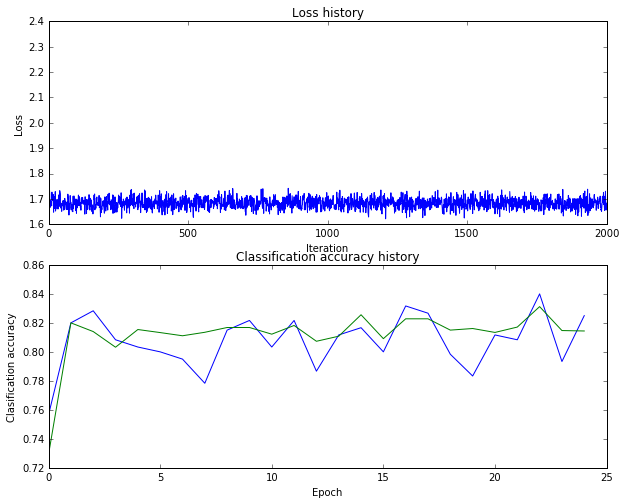

lr 5.000000e-01 reg 0.000000e+00 train accuracy: 0.924080 val accuracy: 0.924600
lr 5.000000e-01 reg 2.500000e-01 train accuracy: 0.822240 val accuracy: 0.843000
lr 5.000000e-01 reg 5.000000e-01 train accuracy: 0.796200 val accuracy: 0.821500
lr 7.000000e-01 reg 0.000000e+00 train accuracy: 0.925500 val accuracy: 0.924800
lr 7.000000e-01 reg 2.500000e-01 train accuracy: 0.819760 val accuracy: 0.843700
lr 7.000000e-01 reg 5.000000e-01 train accuracy: 0.785080 val accuracy: 0.809000
lr 1.000000e+00 reg 0.000000e+00 train accuracy: 0.927700 val accuracy: 0.927000
lr 1.000000e+00 reg 2.500000e-01 train accuracy: 0.823840 val accuracy: 0.846300
lr 1.000000e+00 reg 5.000000e-01 train accuracy: 0.787340 val accuracy: 0.808800
best validation accuracy achieved during cross-validation: 0.927000


In [3]:
# cross-validation on multiple learning rates and regularization
# strengths.
from src.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1,7e-1,5e-1]
regularization_strengths = [0,0.25,0.5]

for rate in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        stats = softmax.train(X_train, y_train, X_val, y_val, rate, reg,
                              num_iters=2000, batch_size=600,
                              verbose=True)
        
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        print 'training accuracy: %f' % (train_acc, )
        
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        print 'validation accuracy: %f' % (val_acc, )
        
        # Plot the loss function and train / validation accuracies
        plt.subplot(2, 1, 1)
        plt.plot(stats['loss_history'])
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(2, 1, 2)
        plt.plot(stats['train_acc_history'], label='train')
        plt.plot(stats['val_acc_history'], label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Clasification accuracy')
        plt.show()
        
        results[(rate, reg)] = train_acc, val_acc
        
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

Let's report the final test set accuracy. We'll also output a precision-recall summary and a confusion matrix.

In [7]:
# evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'Softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )
print

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

print("Classification report for classifier %s:\n%s\n"
      % (best_softmax, metrics.classification_report(y_test, y_test_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_test_pred))

Softmax on raw pixels final test set accuracy: 0.922800

Classification report for classifier <src.classifiers.softmax.Softmax object at 0x11ab2aed0>:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.96      0.98      0.97      1135
          2       0.93      0.89      0.91      1032
          3       0.90      0.91      0.90      1010
          4       0.93      0.93      0.93       982
          5       0.91      0.86      0.89       892
          6       0.93      0.95      0.94       958
          7       0.92      0.93      0.92      1028
          8       0.87      0.89      0.88       974
          9       0.91      0.90      0.90      1009

avg / total       0.92      0.92      0.92     10000


Confusion matrix:
[[ 960    0    1    2    0    4    9    2    2    0]
 [   0 1112    2    2    0    1    4    2   12    0]
 [   5   10  922   18    9    4   10    9   37    8]
 [   3    1   19  916    0   23 